### 5. Model construction

In [15]:
import pandas as pd
import numpy as np
import seaborn as sns
import pickle
import matplotlib.pyplot as plt
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import roc_auc_score, recall_score, f1_score, accuracy_score, confusion_matrix
%matplotlib inline

#### 5.1 Model selection

In [16]:
def score_calculations(X_valid,y_valid, model):
    """This function takes in validation data, corresponding labels and the trained ML model. It calculates auc score, 
       recall score and confusion matrix. 
       
       Input  : Validation data along with corresponding labels and trained model
       Output : AUC score, Recall score and confusion matrix score given by model on validation data
    """
    y_pred = model.predict(X_valid)
    y_proba = model.predict_proba(X_valid)
    auc = roc_auc_score(y_valid, y_proba[:,1])
    binary_recall = recall_score(y_valid, y_pred, average='binary')
    macro_recall = recall_score(y_valid, y_pred, average='macro')
    macro_f1 = f1_score(y_valid, y_pred, average='macro')
    cf = confusion_matrix(y_valid,y_pred)
    return auc,binary_recall,macro_recall, macro_f1, cf

In [17]:
plt.rcParams.update({'font.size': 14})
def plot_confusion_matrix(model,auc,recall,mac_recall, mac_f1,cf):
    """This function takes in model name, auc score, recall score and confusion matrix. It plots confusion matrix along with
       corresponding auc score and recall score.
       
       Input : model name, auc score, recall score(both binary and macro), macro f1 score, confusion matrix
       Output : returns nothing; prints confusion matrix,acu,recall and f1 scores
    """
    cf_matrix = cf
    group_names = ['True Negative','False Positive','False Negative', 'True Positive']
    group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    ax = sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')
    bottom, top = ax.get_ylim()
    ax.set_ylim(bottom + 0.5, top - 0.5)
    plt.ylabel('True label', fontsize=15)
    plt.xlabel('Predicted label', fontsize=15)
    plt.title('\nModel : {}\n AUC score : {:.2f}\n Recall score : {:.2f}\n Macro Recall : {:.2f}\n Macro F1 score : {:.2f}'.format(model,auc,recall,mac_recall,mac_f1), fontsize=16)
    plt.show()
    print('*************************************************\n\n\n')

In [18]:
def find_best_model(X_train,X_valid,y_train,y_valid):
    """This model takes in training data, validation data along with corresponding labels. It trains ML modles namely 
       logistic Regression, Decision Tree Classifier, Random Forest Classifier, Naive Bayes and KNN. Does hyper-parameter
       tuning, plots the confusion matrix obtained on validation data and returns the scores obtained by each model. 
       
       Input  : Training and validation data along with corresponding labels - X_train,X-valid, y_train, y_valid
       Output : Trained models along with corresponding validation auc, recall and confusion matrix scores
    """
    
    # Model 1 : Logistic Regression 
    model_1 = SGDClassifier( class_weight= 'balanced', random_state=0, loss='log')
    param_dict_1 = { 'alpha':[.0001, .001,.01,1,10], 'penalty':["l2", "elasticnet"] }
    cv_model_1 = GridSearchCV(model_1,param_grid=param_dict_1, cv=10, n_jobs=-1,verbose=1,refit='roc_auc',scoring=['roc_auc', 'recall'])
    cv_model_1.fit(X_train,y_train)
    auc_1, recall_1,mac_recall_1,mac_f1, cf_1 = score_calculations(X_valid,y_valid, cv_model_1)
    plot_confusion_matrix("Logistic Regression",auc_1,recall_1,mac_recall_1,mac_f1, cf_1)
    
    # Model 2 : Decision Tree classifier
    model_2 = DecisionTreeClassifier(class_weight="balanced",criterion="gini",  random_state=0)
    param_dict_2 = { "max_depth": [5,10,20,30,50] }
    cv_model_2 = GridSearchCV(model_2,param_grid=param_dict_2, cv=10, n_jobs=-1,verbose=1,refit='roc_auc', scoring=['roc_auc', 'recall'] )
    cv_model_2.fit(X_train,y_train)
    auc_2, recall_2,mac_recall_2,mac_f2,cf_2 = score_calculations(X_valid,y_valid, cv_model_2)
    plot_confusion_matrix("Decision Tree",auc_2,recall_2,mac_recall_2,mac_f2,cf_2) 
    
    # Model 3 : Random Forest Classifier 
    model_3 = RandomForestClassifier(random_state=0, class_weight="balanced",criterion="gini")
    param_dict_3 = { 'max_depth':[ 3,5,7 ] ,'n_estimators': [200,300,400] }
    cv_model_3 = GridSearchCV(model_3,param_grid=param_dict_3, cv=3, n_jobs=-1,verbose=1,refit='roc_auc', scoring=['roc_auc', 'recall'] )
    cv_model_3.fit(X_train,y_train)
    auc_3, recall_3,mac_recall_3,mac_f3, cf_3 = score_calculations(X_valid,y_valid, cv_model_3)
    plot_confusion_matrix("Random Forest",auc_3,recall_3,mac_recall_3,mac_f3, cf_3)    
    
    # Model 4 : Naive Bayes
    model_4 = BernoulliNB()
    param_dict_4 = {'alpha': [0.01, 0.1, 0.5, 1.0, 10.0] }
    cv_model_4=  GridSearchCV(model_4,param_grid=param_dict_4, cv=10, n_jobs=-1,verbose=1,refit='recall', scoring=['roc_auc', 'recall'] )
    cv_model_4.fit(X_train,y_train)
    auc_4, recall_4, mac_recall_4,mac_f4, cf_4 = score_calculations(X_valid,y_valid, cv_model_4)
    plot_confusion_matrix("Naive Bayes",auc_4,recall_4,mac_recall_4,mac_f4, cf_4) 

    # Model 5 : KNN
    model_5 = KNeighborsClassifier(weights="distance", metric= "minkowski", p = 2)
    param_dict_5 = { 'n_neighbors' : [2,3,5,10,15 ] }
    cv_model_5= GridSearchCV(model_5,param_grid=param_dict_5, cv=5, n_jobs=-1,verbose=1,refit='roc_auc', scoring=['roc_auc', 'recall'] )
    cv_model_5.fit(X_train,y_train)
    auc_5, recall_5,mac_recall_5,mac_f5, cf_5 = score_calculations(X_valid,y_valid, cv_model_5)
    plot_confusion_matrix("KNN",auc_5,recall_5,mac_recall_5,mac_f5,cf_5)
    
    auc_list = [auc_1, auc_2, auc_3, auc_4, auc_5]
    recall_list = [ recall_1, recall_2, recall_3, recall_4, recall_5 ]
    mac_recall_list = [ mac_recall_1, mac_recall_2, mac_recall_3, mac_recall_4, mac_recall_5  ]
    mac_f1_list = [mac_f1,mac_f2, mac_f3, mac_f4, mac_f5 ]
    cf_list = [cf_1, cf_2, cf_3, cf_4, cf_5 ]
    model_names = ["Logistic Reg","Decision Trees","Random Forest","Naive Bayes","KNN"]
    model_list = [ cv_model_1, cv_model_2, cv_model_3, cv_model_4, cv_model_5 ]
    
    return auc_list,recall_list,mac_recall_list, mac_f1_list, cf_list,model_names, model_list

Fitting 10 folds for each of 10 candidates, totalling 100 fits


D:\Anaconda\anacondaa\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
D:\Anaconda\anacondaa\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


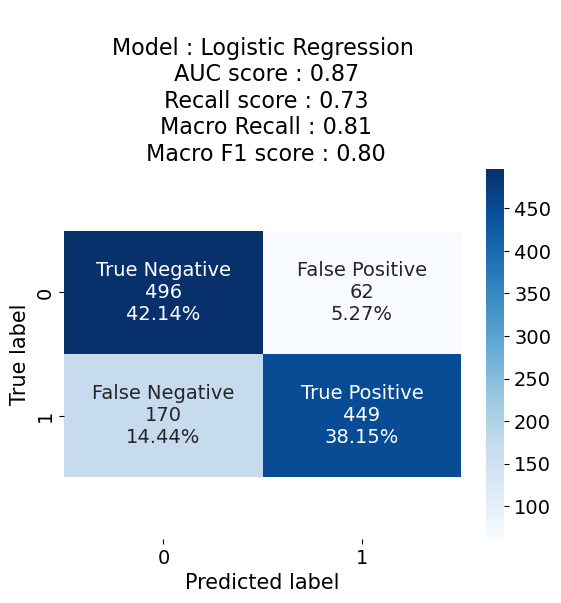

*************************************************



Fitting 10 folds for each of 5 candidates, totalling 50 fits


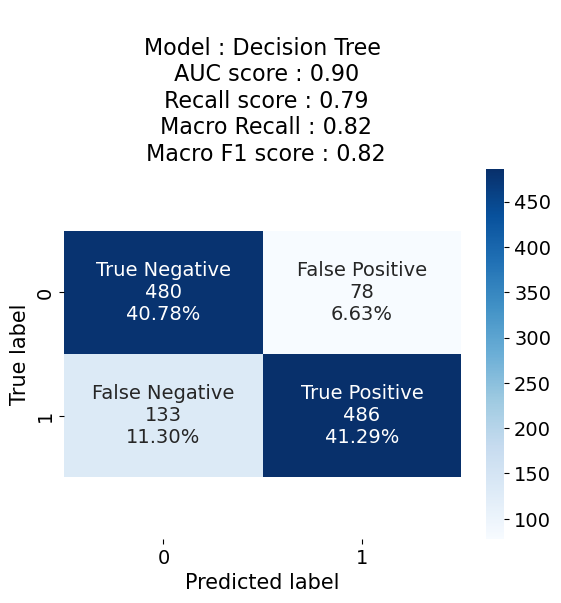

*************************************************



Fitting 3 folds for each of 9 candidates, totalling 27 fits


D:\Anaconda\anacondaa\lib\site-packages\sklearn\model_selection\_search.py:910: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


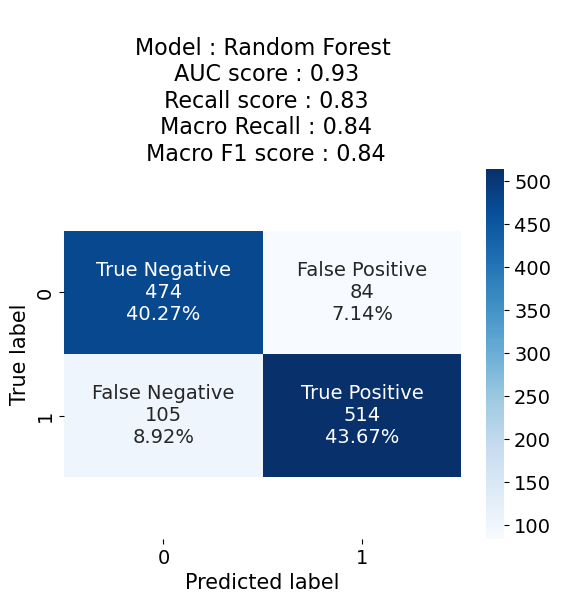

*************************************************



Fitting 10 folds for each of 5 candidates, totalling 50 fits


D:\Anaconda\anacondaa\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


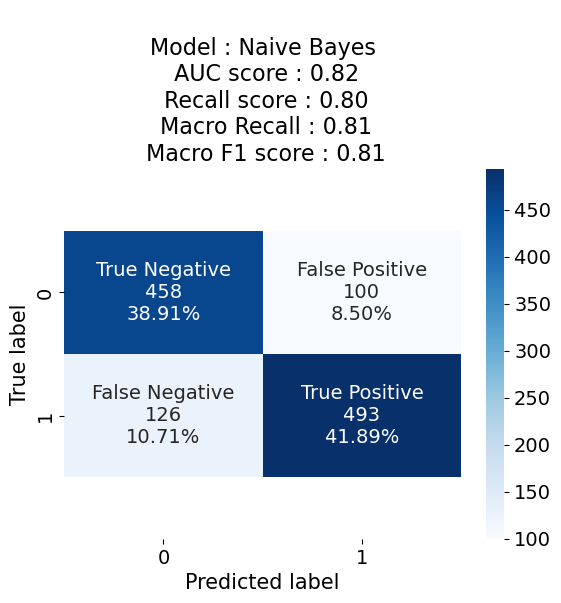

*************************************************



Fitting 5 folds for each of 5 candidates, totalling 25 fits


D:\Anaconda\anacondaa\lib\site-packages\sklearn\neighbors\_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


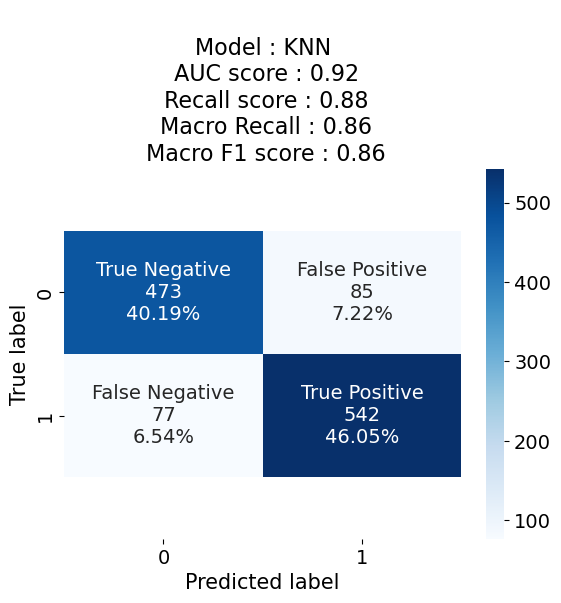

*************************************************





In [19]:
X_train = pd.read_csv('X_train.csv')
y_train = pd.read_csv('y_train.csv')
X_test = pd.read_csv('X_test.csv')
y_test = pd.read_csv('y_test.csv')

X_tr, X_va, y_train, y_valid = train_test_split(X_train,y_train, stratify = y_train, test_size=.1)
auc_list, recall_list, mac_recall_list, mac_f1_list, cf_list, model_names, model_list = find_best_model(X_tr,X_va,y_train,y_valid)

#### 5.2 Comparative study of model performances

In [20]:
def plot_models_score_barplot(auc_list,recall_list,macro_recall, macro_f1, model_names):
    """This function takes in list of auc scores, recall scores and model names. It plots a join-bar char of auc scores and 
       recall scores
       
       input  : auc score list, recall score list, model names list
       output : returns nothing; plots bar chart
    """
    # Numbers of pairs of bars you want
    N = len(auc_list)
    # Data on X-axis
    # Specify the values of blue bars (height)
    blue_bar = auc_list
    # Specify the values of orange bars (height)
    orange_bar = recall_list
    # Specify the values of green bar
    green_bar = macro_recall
    # Specify the valeus of pink bar
    pink_bar = macro_f1
    # Position of bars on x-axis
    ind = np.arange(N)
    # Figure size
    plt.figure(figsize=(15,10))
    # Width of a bar 
    width = 0.2       
    # Plotting
    plt.bar(ind, blue_bar , width, label='AUC score')
    plt.bar(ind + width, orange_bar, width, label='Recall score')
    plt.bar(ind+ (2*width), green_bar, width, label = 'Macro Recall')
    plt.bar(ind+ (3*width), pink_bar, width, label = 'Macro F1')
    plt.xlabel('Machine learning models', fontsize=13)
    plt.ylabel('Scores', fontsize=13)
    plt.title('Comparative study of Machine Learning Models', fontsize=14)
    # xticks()
    # First argument - A list of positions at which ticks should be placed
    # Second argument -  A list of labels to place at the given locations
    plt.xticks(ind + width / 2,model_names, fontsize=13)
    # Finding the best position for legends and putting it
    plt.legend(loc='best', fontsize=13)
    plt.show()

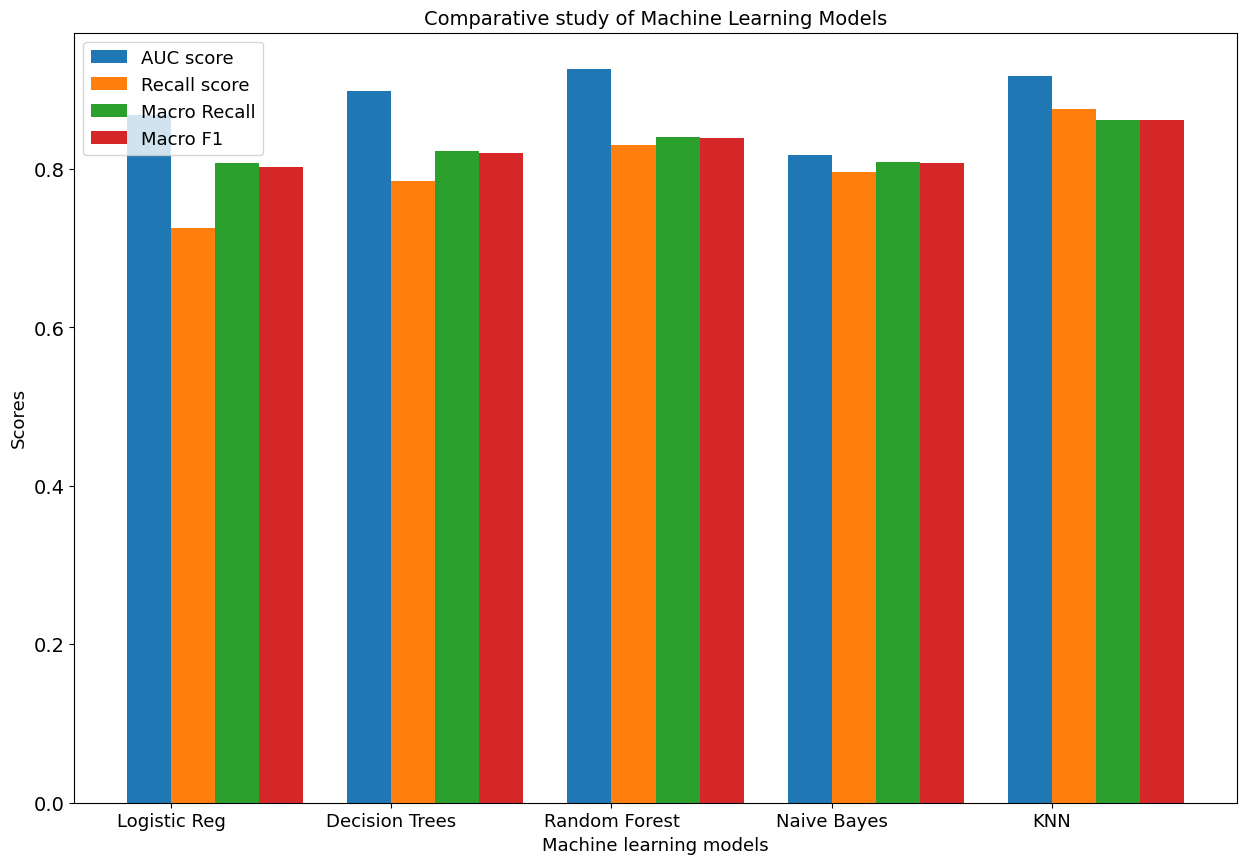

In [21]:
plot_models_score_barplot(auc_list,recall_list,mac_recall_list, mac_f1_list, model_names)

KNN and Random forest perform almost the same, Random forest giving slightly better AUC and KNN on other hand giving better recall. However, one of the reason for KNN performing way better than other models can be that we have used KNN while oversampling using SMOTE. So, we will test both the Random Forest and KNN mdoels and finally deploy the one that outperforms the other.

In [23]:
model_list[2]

GridSearchCV(cv=5, estimator=KNeighborsClassifier(weights='distance'),
             n_jobs=-1, param_grid={'n_neighbors': [2, 3, 5, 10, 15]},
             refit='roc_auc', scoring=['roc_auc', 'recall'], verbose=1)

In [24]:
model_list[4].best_estimator_

KNeighborsClassifier(n_neighbors=15, weights='distance')

D:\Anaconda\anacondaa\lib\site-packages\sklearn\neighbors\_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


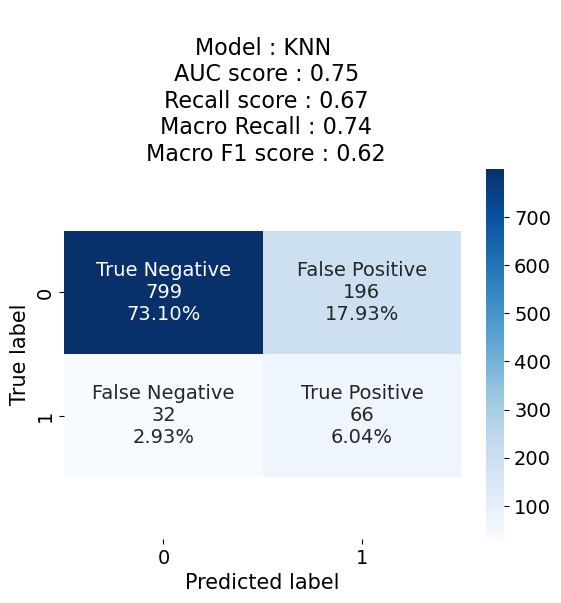

*************************************************





In [26]:
X_train = pd.read_csv('X_train.csv')
y_train = pd.read_csv('y_train.csv')
X_test = pd.read_csv('X_test.csv')
y_test = pd.read_csv('y_test.csv')

model = KNeighborsClassifier(weights="distance", metric= "minkowski", p = 2, n_neighbors=15)
model.fit(X_train,y_train)
auc, recall_binary,mac_recall,f1, cf = score_calculations(X_test,y_test,model)
plot_confusion_matrix("KNN",auc, recall_binary,mac_recall,f1, cf)

In [27]:
model_list[2]

GridSearchCV(cv=3,
             estimator=RandomForestClassifier(class_weight='balanced',
                                              random_state=0),
             n_jobs=-1,
             param_grid={'max_depth': [3, 5, 7],
                         'n_estimators': [200, 300, 400]},
             refit='roc_auc', scoring=['roc_auc', 'recall'], verbose=1)

In [28]:
model_list[2].best_estimator_

RandomForestClassifier(class_weight='balanced', max_depth=7, n_estimators=400,
                       random_state=0)

C:\Users\rishikesh\AppData\Local\Temp\ipykernel_11236\838416238.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model_1.fit(X_train,y_train)


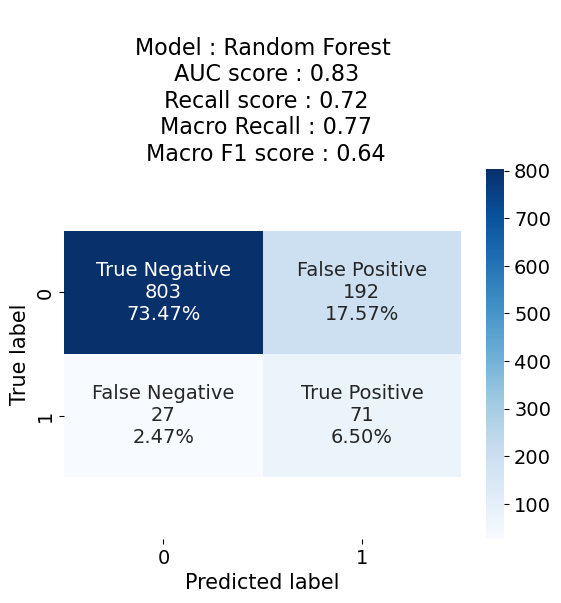

*************************************************





In [31]:
# Random Forest Classifier 
model_1 = RandomForestClassifier(random_state=0, class_weight="balanced",criterion="gini", max_depth=7, n_estimators=400)
model_1.fit(X_train,y_train)
auc_1, recall_1,mac_recall_1,mac_f1_1, cf_1 = score_calculations(X_test,y_test, model_1)
plot_confusion_matrix("Random Forest",auc_1, recall_1,mac_recall_1,mac_f1_1, cf_1)    

So, Random forest seem to outperform KNN on test set. so, we will select Random Forest for model deployment. The fall in the performance of model on test set can be attributed to the fact that training data was well balanced, the real world data however is highly imbalance.

#### 5.3 Saving the final model

In [34]:
# save the model to disk
filename = 'random_forest_model.sav'
pickle.dump(model, open(filename, 'wb'))